### Demo: Metaprogramming + Manual Prediction
*(built during problem with scoring on test set)*

 - Metaprogramming technique: What are main differences between `pieces` and `pieces2`
 - Calc accuracy "manually" for scoring another dataset


### Setup

In [1]:
from fastai2.vision.all import *

def piece_class_parse(fn): 
    fn = fn.split('_')[1]
    fn = fn.split('.')[0]
    return fn

path = Path('../../../rf-chess-data/cropped_v1/')

In [3]:
pieces = ImageDataLoaders.from_name_func(
                path, 
                get_image_files(path),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

In [2]:
pieces2 = ImageDataLoaders.from_name_func(
                path, 
                get_image_files(path),
                valid_pct=0.2, 
                seed=42,
                label_func=piece_class_parse, 
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                )

In [7]:
learn = load_learner('../models/demo-model-1.pkl')
learn.path = path

### Compare the two TfmDL's with metaprogramming

In [15]:
pieces2.valid

In [14]:
pieces.valid

In [27]:
pieces2.valid.items == pieces.valid.items

True

In [107]:
# how many methods / properties does this have?
len(dir(pieces))

205

In [104]:
d1, d2 = {}, {}
for attr_name in dir(pieces):
    
    if attr_name[:2] == '__':
        continue
    try:
        attr_1 = getattr(pieces, attr_name)
        attr_2 = getattr(pieces2, attr_name)
        str(attr_1)
        d1[attr_name] = attr_1
        d2[attr_name] = attr_2
    except:
        pass

In [109]:
same_attrs = []
for k in d1.keys():
    if d1[k] == d2[k]:
        same_attrs.append(k)
print(f"number of same attributes: {len(same_attrs)}")

number of same attributes: 75


In [110]:
diff_attrs = []
for k in d1.keys():
    if d1[k] != d2[k]:
        diff_attrs.append(k)
print(f"number of same attributes: {len(diff_attrs)}")

number of same attributes: 60


In [111]:
def is_prop(attr):
    ''' return True if attr is a property '''
    try:
        attr.__call__()
        # calls
        return False
    except AttributeError:
        # has no call
        return True
    except:
        #calls but bad args
        return False        

number of diff props: 16


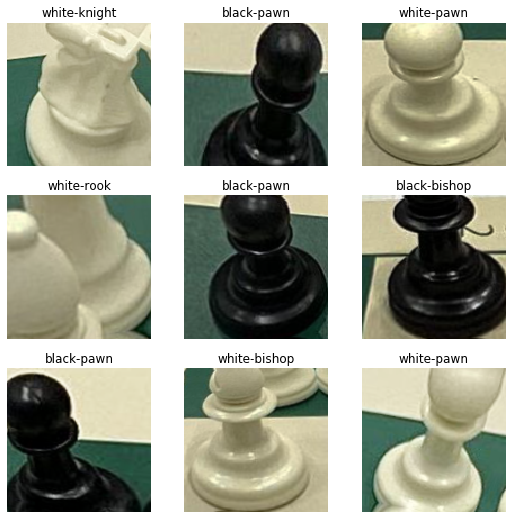

In [112]:
diff_props = []
for k in d1.keys():
    if is_prop(d1[k]):
        if d1[k] != d2[k]:
            diff_props.append(k)
print(f"number of diff props: {len(diff_props)}")

In [113]:
diff_props

['add',
 'dataset',
 'decodes',
 'encodes',
 'fake_l',
 'fs',
 'init_enc',
 'loaders',
 'rng',
 'setups',
 'tfms',
 'train',
 'train_ds',
 'transform',
 'valid',
 'valid_ds']

In [132]:
# `L` classes don't compare with == 
# even tho they are the same
t1 = pieces.tfms
t2 = pieces2.tfms
print(t1 == t2)
t1, t2

False


((#2) [Pipeline: PILBase.create,Pipeline: partial -> Categorize],
 (#2) [Pipeline: PILBase.create,Pipeline: partial -> Categorize])

In [129]:
diff_props_nonL = [e for e in diff_props if not(isinstance(d1[e], L))]
diff_props_nonL

['dataset',
 'fake_l',
 'loaders',
 'rng',
 'train',
 'train_ds',
 'valid',
 'valid_ds']

In [133]:
pieces.rng

In [137]:
pieces.valid

In [141]:
type(pieces.dataset)

fastai2.data.core.Datasets

In [142]:
pieces.loaders

In [149]:
type(pieces)

fastai2.data.core.DataLoaders

### Do manual accuracy check

In [42]:
from sklearn.metrics import accuracy_score

In [54]:
def my_acc2(learn, test, n=100):

    preds_train = [learn.predict(item) for item in learn.dls.train.items[:n]]
    # preds_train = [learn.predict(item[1]) for item in learn.dls.dataset]
    y_hat = [e[1].tolist() for e in preds_train]
    y_actual = [e[1].tolist() for e in learn.dls.dataset[:n]]
    acc_t = accuracy_score(y_actual, y_hat)

    preds_test = [learn.predict(item) for item in test.train.items[:n]]    
    y_hat = [e[1].tolist() for e in preds_test]
    y_actual = [e[1].tolist() for e in test.dataset[:n]]
    acc_v = accuracy_score(y_actual, y_hat)
    
    return acc_t, acc_v

In [56]:
my_acc2(learn, pieces2, n=100)

(1.0, 1.0)

In [50]:
old_cbs = learn.cbs
old_cbs

(#8) [TrainEvalCallback,Recorder,ProgressCallback,GatherPredsCallback,GatherPredsCallback,GatherPredsCallback,GatherPredsCallback,GatherPredsCallback]

In [51]:
learn.cbs = L([])

### Build test set and do manula predictions

In [62]:
test_path = Path('../../../other-chess-data/regulation-test-1/')

In [63]:
test_dl = ImageDataLoaders.from_name_func(
                test_path, 
                fnames=get_image_files(test_path),
                valid_pct=0.0, 
                seed=None,
                label_func=piece_class_parse,
                item_tfms=RandomResizedCrop(128, min_scale=0.5),
                batch_tfms=aug_transforms(),
                bs=16,
                )

In [64]:
my_acc2(learn, test_dl, n=60)

(1.0, 0.38333333333333336)

In [65]:
1/12  #baseline

0.08333333333333333

In [66]:
it = test_dl.train.items[0]
pred = learn.predict(it)
pred

('white-pawn',
 tensor(9),
 tensor([0.0035, 0.0024, 0.0026, 0.0632, 0.0006, 0.0082, 0.0114, 0.0050, 0.0210,
         0.5172, 0.0013, 0.3637]))

In [93]:
n=60
tmp = []
for  _it in test_dl.items[:n]:
    pred = learn.predict(_it)
    tmp.append([pred[0], piece_class_parse(_it.name), _it])
    

##### Style the printouts

In [95]:
n=13
pretty = [[col[0].rjust(n), col[1].rjust(n)] for col in tmp]

In [101]:
correct = [e for e in pretty if e[1] == e[0]]
correct.sort(key=lambda x: x[1] )
print( 'predicted          | actual')
correct

predicted          | actual


[['   black-king', '   black-king'],
 ['   black-king', '   black-king'],
 ['   black-pawn', '   black-pawn'],
 ['   black-pawn', '   black-pawn'],
 ['   black-pawn', '   black-pawn'],
 ['   black-pawn', '   black-pawn'],
 ['   black-rook', '   black-rook'],
 ['   black-rook', '   black-rook'],
 ['   black-rook', '   black-rook'],
 ['   black-rook', '   black-rook'],
 ['   white-rook', '   white-rook'],
 ['   white-rook', '   white-rook'],
 ['   white-rook', '   white-rook'],
 ['  black-queen', '  black-queen'],
 [' black-bishop', ' black-bishop'],
 [' black-knight', ' black-knight'],
 [' black-knight', ' black-knight'],
 [' black-knight', ' black-knight'],
 [' black-knight', ' black-knight'],
 [' white-knight', ' white-knight'],
 [' white-knight', ' white-knight'],
 [' white-knight', ' white-knight'],
 [' white-knight', ' white-knight']]

In [100]:
incorrect = [e for e in pretty if e[1] != e[0]]
incorrect.sort(key=lambda x: x[1] )
print( 'predicted          | actual')
incorrect

predicted          | actual


[[' black-knight', '   black-king'],
 [' black-knight', '   black-king'],
 ['   white-pawn', '   black-king'],
 ['   white-pawn', '   black-pawn'],
 ['   white-pawn', '   black-rook'],
 [' white-knight', '   white-king'],
 ['   white-pawn', '   white-king'],
 [' white-knight', '   white-king'],
 ['   black-pawn', '   white-king'],
 ['   black-pawn', '   white-pawn'],
 ['   white-rook', '   white-pawn'],
 ['   black-pawn', '   white-pawn'],
 ['   black-king', '   white-pawn'],
 ['   black-pawn', '   white-pawn'],
 ['   white-pawn', '   white-rook'],
 ['   white-pawn', '   white-rook'],
 [' black-knight', '  black-queen'],
 [' black-knight', '  black-queen'],
 [' black-knight', '  black-queen'],
 ['   white-pawn', '  black-queen'],
 ['   black-pawn', '  white-queen'],
 [' white-knight', '  white-queen'],
 ['   black-pawn', '  white-queen'],
 ['   black-pawn', '  white-queen'],
 [' white-knight', '  white-queen'],
 ['   white-pawn', ' black-bishop'],
 [' white-knight', ' black-bishop'],
 